<a href="https://colab.research.google.com/github/zinab4/LogisticRegression/blob/main/Untitled58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape,Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

# Add this line to create the 'layers' alias
layers = tf.keras.layers

from IPython import display
print ("tensorflow version: ", tf.__version__ ) # Changed tensorflow to tf here as well
# ... rest of your code

tensorflow version:  2.18.0


In [ ]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import time
import re
from keras.preprocessing.image import img_to_array

In [ ]:
tensorflow.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1067537449208145725
 xla_global_id: -1]

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/celeba-dataset


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle (2).json to kaggle (2) (5).json


In [ ]:
import pandas as pd

# Path to the attribute file, adjust if needed
attr_file_path = '/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/list_attr_celeba.csv'

# Load the attributes CSV into a DataFrame
data = pd.read_csv(attr_file_path)

# Show the first 5 rows
print(data.head())


     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  We

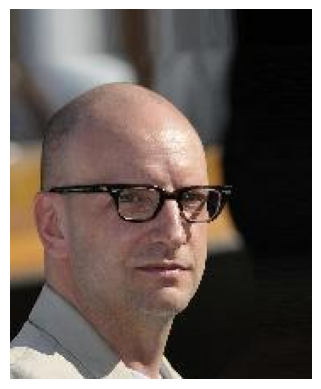

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

nested_folder = '/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'

image_filename = '196248.jpg'
image_path = os.path.join(nested_folder, image_filename)

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
#let's check the CPU/GPU devices used and print it to the screen

tensorflow.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9378594024844420419
 xla_global_id: -1]

In [ ]:
data.shape

(202599, 41)

In [ ]:

from PIL import Image
import numpy as np
import os

images_folder = '/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'

def load_image_as_array(image_id):
    path = os.path.join(images_folder, image_id)
    img = Image.open(path)
    return np.array(img)

img_array = load_image_as_array(data.loc[0, 'image_id'])
print(img_array.shape)


(218, 178, 3)


In [ ]:
BUFFER_SIZE = 10000

BATCH_SIZE = 32

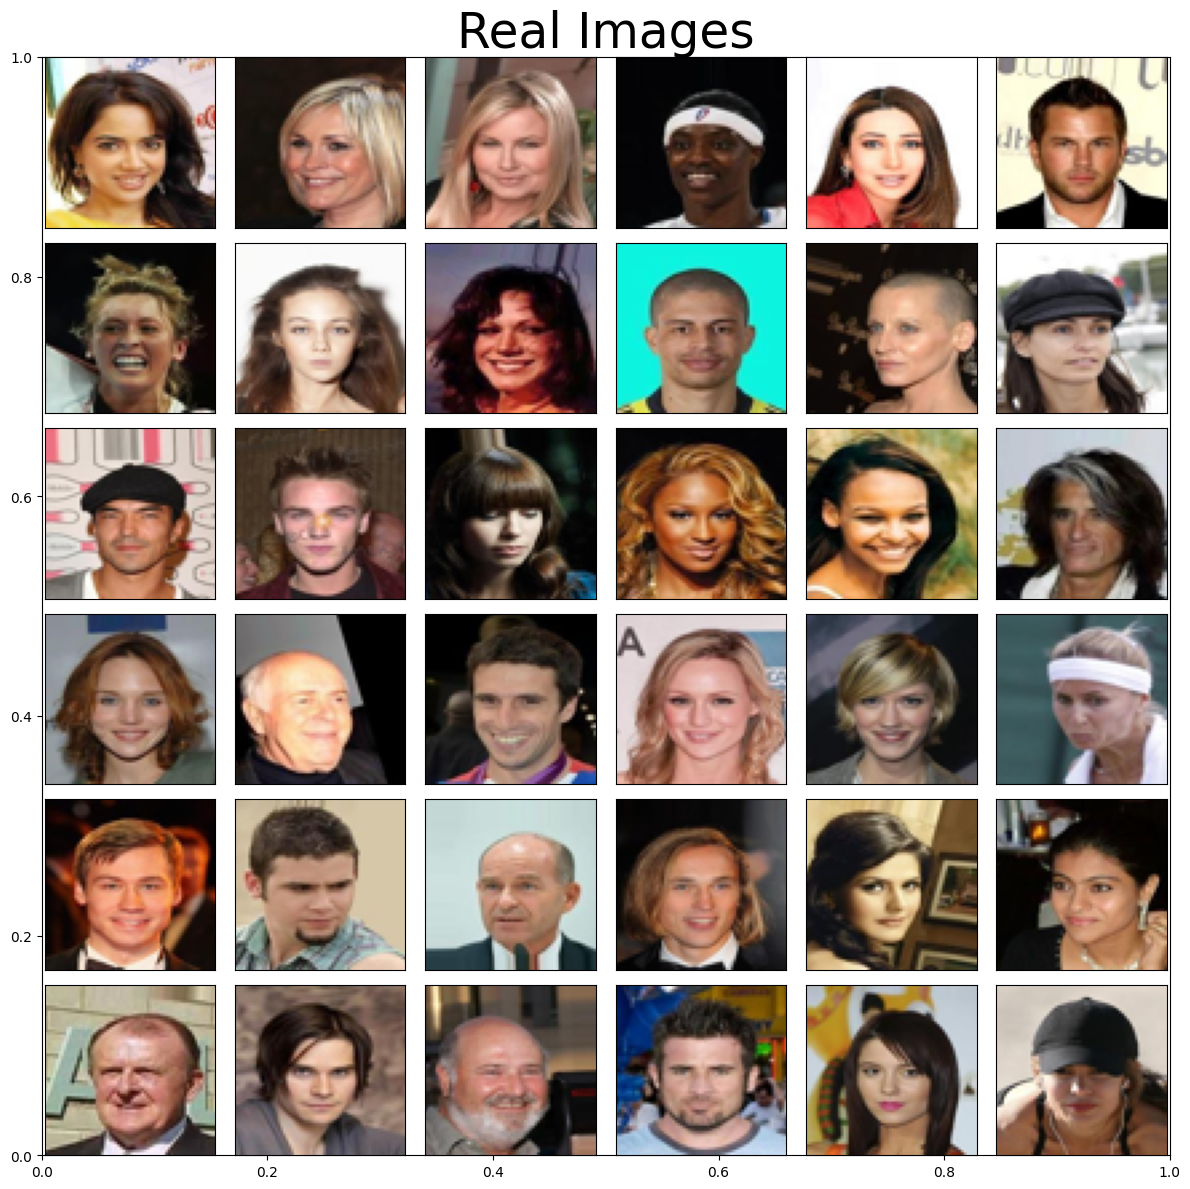

In [ ]:
# Define the directory containing the images
DATA_DIR = '/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba'

# Define the desired image size for the GAN
IMG_SIZE = 64 # Set this to match the GAN's target size

# --- New code to load images ---
from PIL import Image
import numpy as np
import os
import random # Import random to pick images

# Get a list of all image filenames
all_image_files = os.listdir(DATA_DIR)

# Filter for image files (e.g., ending with .jpg, .jpeg, .png)
image_extensions = ['.jpg', '.jpeg', '.png']
all_image_files = [f for f in all_image_files if os.path.splitext(f)[1].lower() in image_extensions]


# Define how many images you want to plot (should be sqr * sqr)
num_images_to_plot = 6 * 6 # Since you call plot_images(6)

# Select a random sample of image filenames
if len(all_image_files) >= num_images_to_plot:
    selected_image_files = random.sample(all_image_files, num_images_to_plot)
else:
    # Handle the case where there are fewer images than you want to plot
    print(f"Warning: Only {len(all_image_files)} images available, attempting to plot fewer.")
    selected_image_files = all_image_files
    num_images_to_plot = len(all_image_files) # Update num_images_to_plot

# Load the selected images into a list called _img and resize them
_img = []
for filename in selected_image_files:
    try:
        img_path = os.path.join(DATA_DIR, filename)
        img = Image.open(img_path)
        # Resize images to the desired GAN size
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
        # Ensure the image has 3 channels (convert grayscale to RGB if necessary)
        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,)*3, axis=-1)
        elif img_array.shape[-1] == 4: # Remove alpha channel if present
             img_array = img_array[..., :3]
        # Normalize pixel values to be between -1 and 1 as per the plotting function and GAN
        img_array = (img_array.astype(np.float32) / 127.5) - 1.0
        _img.append(img_array)
    except Exception as e:
        print(f"Could not load or process image {filename}: {e}")
        # Skip this image and continue
        continue

# Convert _img to a numpy array for easier indexing
_img = np.array(_img)

# --- End of new code ---


def plot_images(sqr = 5):
    # Adjust the figure size based on the number of images
    plt.figure(figsize = (sqr * 2, sqr * 2))
    plt.title("Real Images",fontsize = 35)
    # Plot only up to the number of images available in _img
    num_to_plot = min(sqr * sqr, len(_img))
    for i in range(num_to_plot):
        plt.subplot(sqr,sqr,i+1)
        # Ensure values are in the range [0, 1] for imshow after reversing the normalization
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout() # Improve layout
    plt.show() # Display the plot

# to plot images
# Call plot_images with the desired number of images per side
plot_images(6)

In [ ]:
batch_size = 32
# Convert the loaded and resized images to a TensorFlow dataset
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [ ]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    # Use tf.keras.layers.Dense, adjust size to produce features that result in 4x4 after reshape
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(latent_dim,)))
    # Use tf.keras.layers.Reshape to start with a spatial dimension that can be upsampled
    model.add(tf.keras.layers.Reshape((4,4,512)))

    # Upsampling layers to reach 64x64
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 4x4 -> 8x8
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 8x8 -> 16x16
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 16x16 -> 32x32
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 32x32 -> 64x64
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # Final layer to output 64x64x3 image
    model.add(tf.keras.layers.Conv2D(3,4,strides = 1, padding = 'same',activation = 'tanh')) # Keep 64x64 size

    return model

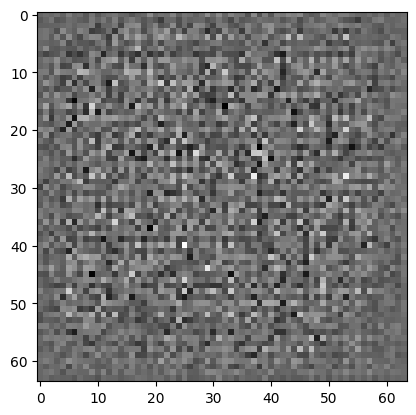

In [ ]:
generator = Generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generator = Generator()
generator.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_39             │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_45 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_46 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 64, 64, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 3)      │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,607,939 (13.76 MB)

 Trainable params: 3,606,979 (13.76 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
def Discriminator():
    model = tf.keras.models.Sequential()
    # Define SIZE before using it in the Input layer
    SIZE = 64
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 64x64 -> 32x32
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 32x32 -> 16x16
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 16x16 -> 8x8
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 8x8 -> 4x4
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 4x4 -> 2x2 - Changed stride to 2
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten()) # (None, 2, 2, 512) -> (None, 2048)
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [ ]:

discriminator = Discriminator()
discriminator.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 128)    │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 128)    │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 4, 4, 256)      │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 2, 2, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,943,425 (15.04 MB)

 Trainable params: 3,941,889 (15.04 MB)

 Non-trainable params: 1,536 (6.00 KB)

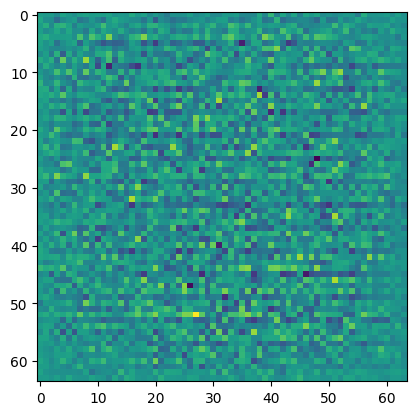

In [ ]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [ ]:
optimizer_g = tf.keras.optimizers.RMSprop(
    learning_rate=.0001,
    clipvalue=1.0,
    decay=1e-8
)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
optimizer_d = tf.keras.optimizers.RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [ ]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)


    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Use the correct optimizers to apply gradients
    optimizer_g.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_d.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss


In [ ]:
def plot_generated_images(square=5, epochs=0):
    plt.figure(figsize=(10, 10))
    for i in range(square * square):
        if epochs != 0:
            if i == (square * square) // 2:
                plt.title(f"Generated Image at Epoch: {epochs}", fontsize=32, color='black')

        plt.subplot(square, square, i + 1)
        noise = np.random.normal(0, 1, (1, latent_dim))
        img = generator(noise, training=False)
        plt.imshow(np.clip((img[0, ...] + 1) / 2, 0, 1))  # Normalize from [-1, 1] to [0, 1]
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

    plt.tight_layout()
    plt.show()


In [ ]:
import time
def train(epochs,dataset):

    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
# Call the train function
train(100,dataset)



Epoch : 1
 Time:11.0
Generator Loss: 3.9897186756134033 Discriminator Loss: 0.02075602300465107

Epoch : 2
 Time:12.0
Generator Loss: 4.073416709899902 Discriminator Loss: 0.018642622977495193

Epoch : 3
 Time:11.0
Generator Loss: 3.872316598892212 Discriminator Loss: 0.02187005616724491

Epoch : 4
 Time:11.0
Generator Loss: 3.6865687370300293 Discriminator Loss: 0.026111241430044174

Epoch : 5
 Time:11.0
Generator Loss: 3.2272849082946777 Discriminator Loss: 0.04117897152900696

Epoch : 6
 Time:12.0
Generator Loss: 2.1441047191619873 Discriminator Loss: 0.1271086037158966

Epoch : 7
 Time:20.0
Generator Loss: 1.0623652935028076 Discriminator Loss: 0.43512988090515137

Epoch : 8
 Time:12.0
Generator Loss: 4.602902412414551 Discriminator Loss: 0.01045147329568863

Epoch : 9
 Time:20.0
Generator Loss: 4.487152099609375 Discriminator Loss: 0.011771626770496368

Epoch : 10
 Time:12.0
Generator Loss: 4.219997882843018 Discriminator Loss: 0.015115330927073956

Epoch : 11
 Time:14.0
Generato

In [ ]:
# Call the train function
train(500,dataset)


Epoch : 1
 Time:12.0
Generator Loss: 0.456073522567749 Discriminator Loss: 1.6364216804504395

Epoch : 2
 Time:20.0
Generator Loss: 2.29784893989563 Discriminator Loss: 0.2913540303707123

Epoch : 3
 Time:20.0
Generator Loss: 1.4209816455841064 Discriminator Loss: 0.36132916808128357

Epoch : 4
 Time:11.0
Generator Loss: 3.0113279819488525 Discriminator Loss: 0.10310107469558716

Epoch : 5
 Time:11.0
Generator Loss: 3.519056558609009 Discriminator Loss: 0.0633765161037445

Epoch : 6
 Time:11.0
Generator Loss: 3.242233991622925 Discriminator Loss: 0.09104952961206436

Epoch : 7
 Time:11.0
Generator Loss: 3.804152011871338 Discriminator Loss: 0.07035038620233536

Epoch : 8
 Time:20.0
Generator Loss: 4.230941295623779 Discriminator Loss: 0.0510781854391098

Epoch : 9
 Time:12.0
Generator Loss: 3.409806251525879 Discriminator Loss: 0.07555554062128067

Epoch : 10
 Time:12.0
Generator Loss: 2.8722472190856934 Discriminator Loss: 0.1251440793275833

Epoch : 11
 Time:11.0
Generator Loss: 1.3

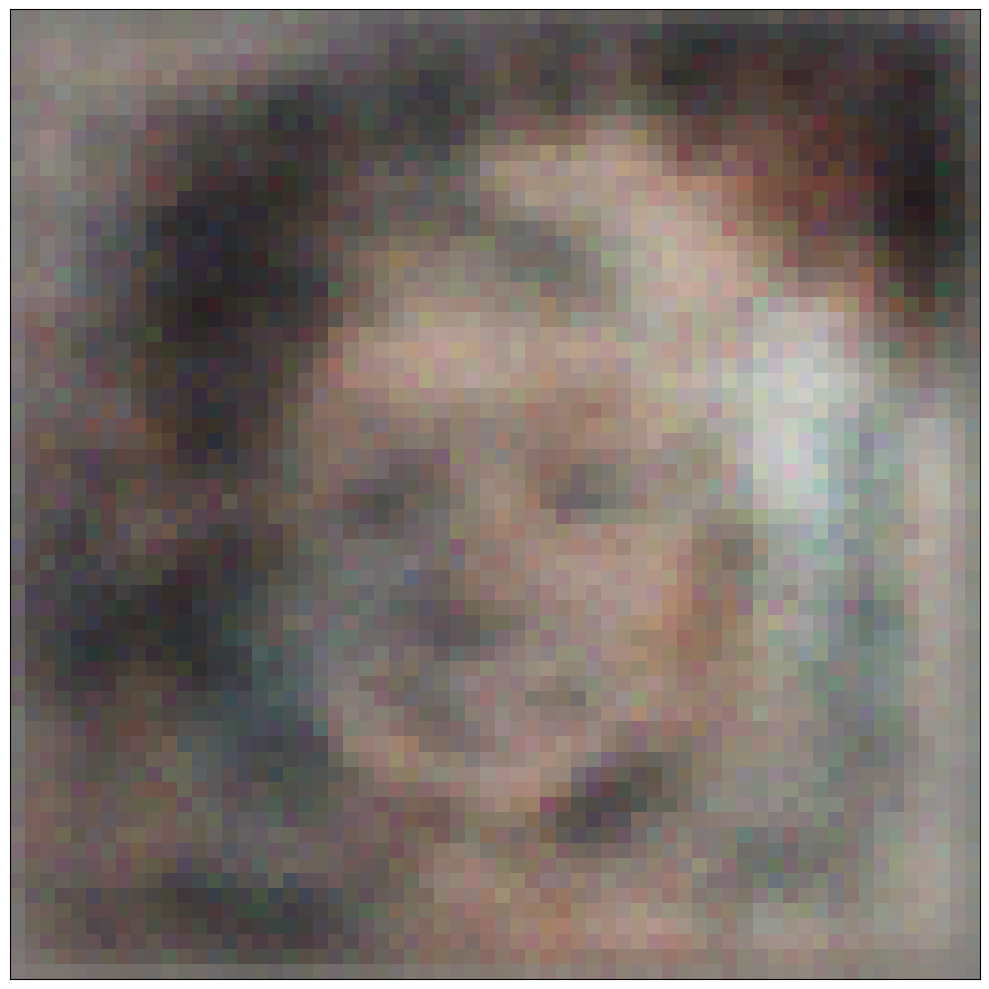

In [ ]:
plot_generated_images(1)

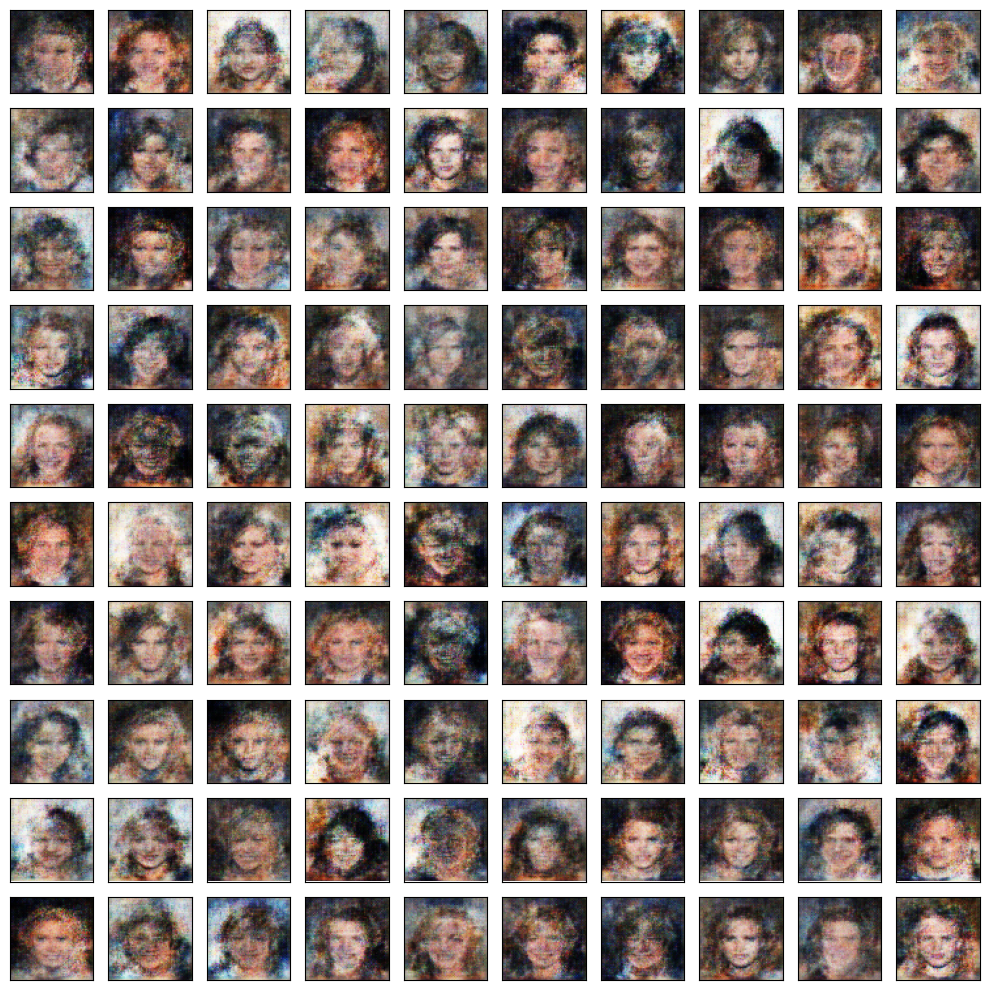

In [ ]:
plot_generated_images(10)

In [ ]:
plot_generated_images(7)